## How does reweighting and MBAR work?

This notebook demonstrates reweighting and MBAR by performing statistical tests on quantities calculated from samples of a set of of 1D harmonic oscillators, for which the true free energy differences can be computed analytically. 

For a 1D harmonic oscillator with spring constant $K$, the potential is given by

$V(x;K) = \frac{1}{2}K(x-x_0)^2$

The equilibrium distribution is given analytically by:

$p(x;\beta,K) = \sqrt{\frac{\beta K}{2\pi}} e^{-\frac{\beta K (x-x_0)^2}{2}}$

The dimensionless free energy is therefore:

  $f(\beta,K) = - \frac{1}{2} \ln \left( \frac{2 \pi}{\beta K} \right)$


## Imports

In [51]:
import sys
import numpy as np
from pymbar import testsystems, exp, exp_gauss, bar, MBAR, FES
from pymbar.utils import ParameterError
import scipy

In [52]:
import logging
import sys
import matplotlib.pyplot as plt

We set up logging for `pymbar` so we can look at the verbose output. 

In [53]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Introducing some helper functions we will use


helper function for determining how many standard deviations away data is from the expected value. 

In [95]:
def stddev_away(namex, errorx, dx):
    if dx > 0:
        print(f"{namex} differs by {errorx / dx:.3f} standard deviations from analytical")
    else:
        print(f"{namex} differs by an undefined number of standard deviations")

`get_analytical`generates the analytical estimates of various functions of a harmonic oscillator.

For a harmonic oscillator with spring constant $K$, $x \sim N(x_0, \sigma^2$), where $\sigma = (\beta K)^{-1/2}$

We can calculate expectation values with reweighting as well.  

- The dimensionless free energies of each oscillator are $f = - \ln \sqrt{\frac{2 \pi}{\beta K}}$, where $K$ is the spring constant. 
- The expectation of RMS displacement in a harmonic oscillator is just the $\sigma$ of the oscillator. 
- The expectation value of the potential energy is $\frac{1}{2\beta}$, independent of the spring constant.
- The expectation value of the position is simply the mean (center) of the distribution, $x_0$ (or $O$ in the code below)
- The expectation value of $\langle x^2 \rangle$ is $\frac{1 + \beta Kx_0^2}{\beta K}$.

In [54]:
def get_analytical(beta, K, O, observables):

    print("Computing dimensionless free energies analytically...")
    sigma = (beta * K) ** -0.5
    f_k_analytical = -np.log(np.sqrt(2 * np.pi) * sigma)
    Delta_f_ij_analytical = f_k_analytical - np.vstack(f_k_analytical)
    A_k_analytical = dict()
    A_ij_analytical = dict()
    for observe in observables:
        if observe == "RMS displacement":
            # mean square displacement
            A_k_analytical[observe] = sigma
        if observe == "potential energy":
            # By equipartition
            A_k_analytical[observe] = 1 / (2 * beta) * np.ones(len(K), float)
        if observe == "position":
            # observable is just the position parameter
            A_k_analytical[observe] = O 
        if observe == "position^2":
            # observable is the position^2
            A_k_analytical[observe] = (1 + beta * K * O**2) / (beta * K)
        A_ij_analytical[observe] = A_k_analytical[observe] - np.vstack(A_k_analytical[observe])
    return f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical

### Simple, one state reweighting. 

Assume because of whatever the issues of our experiments, we can only collect data from a harmonic potential, with harmonic center $\mu=0$, and $K=1$.  But let's say what we ACTUALLY want, for whatever bizzare reason, are statistics for samples collected with $\mu=2$ and $K=3$. 
For simplicity, we set $T=1$, so $\beta=1$.

Here's the potentials:

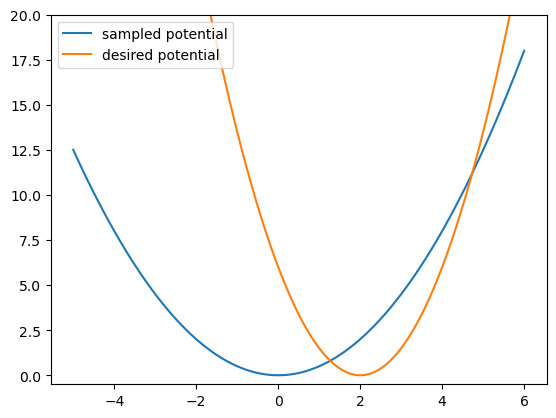

In [4]:
sampled_K = 1
sampled_mean = 0
desired_K = 3
desired_mean = 2
x=np.linspace(-5,6,1000)
plt.plot(x,(sampled_K/2)*(x-sampled_mean)**2,label="sampled potential")
plt.plot(x,(desired_K/2)*(x-desired_mean)**2,label="desired potential")
plt.ylim([-0.5,20])
plt.legend()
plt.show()

And the sampled, normalized distributions:

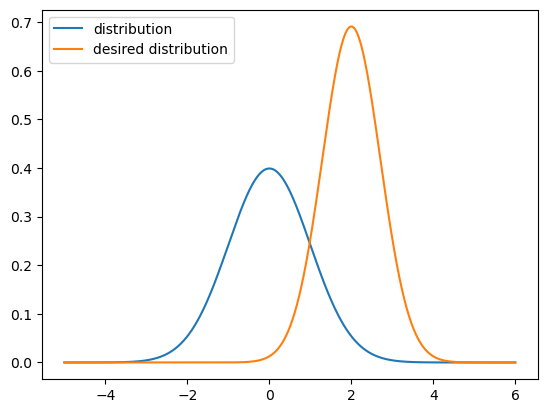

In [5]:
norm_sampled = (2*np.pi/sampled_K)**(-0.5)
norm_desired = (2*np.pi/desired_K)**(-0.5)

plt.plot(x,norm_sampled*np.exp(-(sampled_K/2)*(x-sampled_mean)**2),label="distribution")
plt.plot(x,norm_desired*np.exp(-(x-desired_mean)**2),label="desired distribution")
plt.legend()
plt.show()

Now collect samples from the sampled distribution.

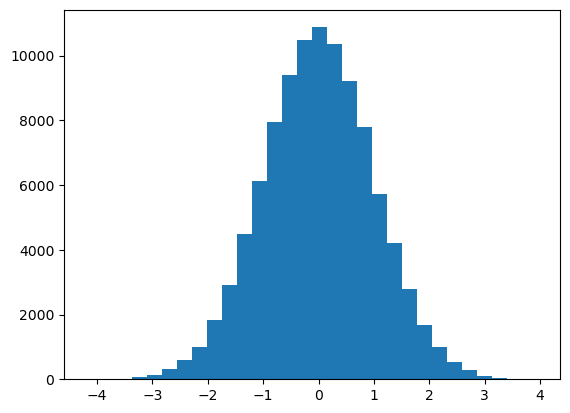

In [36]:
sampled_x = np.random.normal(loc=sampled_mean,scale=sampled_K**(-0.5), size=100000)
plt.hist(sampled_x,bins=30)
plt.show()

Now compute the weights for each SAMPLED point, in the desired distribution, which will be $e^{\beta \Delta F- \beta \Delta U(x)}$.  

What is $\Delta U$?  $U_{desired}-U_{sampled} = \frac{1}{2}K_{desired}(x-x_{0,desired})^2 - \frac{1}{2} K_{sampled}(x-x_{0,sampled})^2$  

In [37]:
dU = 0.5 * (desired_K*(sampled_x-desired_mean)**2 - sampled_K*(sampled_x-sampled_mean)**2)

Now, our estimated $\Delta F = -\beta^{-1} \ln \frac{1}{N}\sum_{n=1}^N e^{\beta F -\Delta U(x_n)} = -\beta^{-1} \langle e^{\beta F -\Delta U(x)} \rangle$

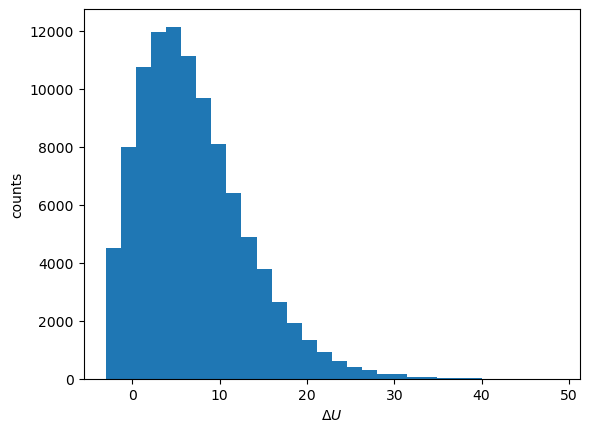

In [38]:
plt.hist(dU,bins=30)
plt.xlabel(r'$\Delta U$')
plt.ylabel('counts')
plt.show()

In [39]:
dF = -np.log(np.mean(np.exp(-dU)))
print(dF)

0.5585600555576447


But a key connetion here - $\Delta F$ is also the log ratio of the normalizing constants.

In [40]:
true_dF = np.log(norm_desired/norm_sampled)
print(true_dF)

0.5493061443340548


The normalization factor in front of a probability distribution is the partition function!

What are the weights for each of the SAMPLED distribution in the unsampled distribution?

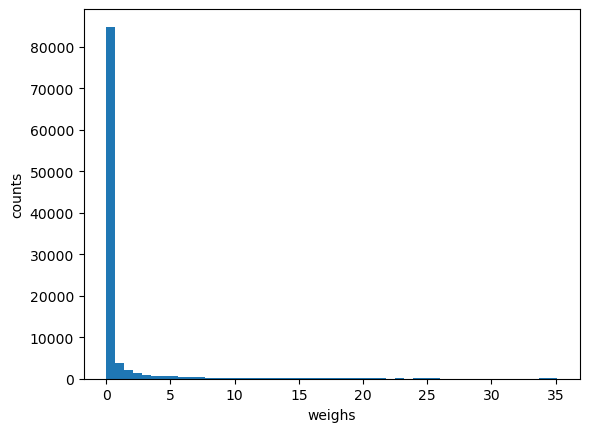

In [41]:
weights = np.exp(dF-dU)
plt.hist(weights,bins=50)
plt.xlabel('weighs')
plt.ylabel('counts')
plt.show()

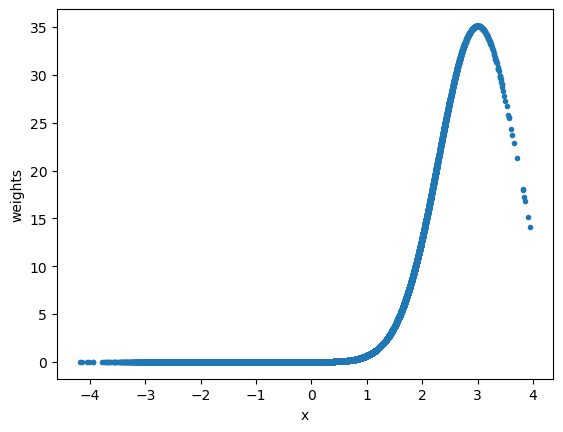

In [42]:
weights = np.exp(dF-dU)
plt.plot(sampled_x,weights,ls='',marker='.')
plt.xlabel('x')
plt.ylabel('weights')
plt.show()

Now, compute the mean of this distribution with a weighted average?  What should it be?

In [43]:
np.mean(sampled_x*weights)

1.9944417564799168

Now, let's do multistate reweighting! (MBAR!)

We'll cary out a number of replications of an experiment in which i.i.d. samples are drawn from a set of $K$ harmonic oscillators are produced.  For each replicate, we estimate the dimensionless free energy differences and mean-square displacements (an observable), as well as their uncertainties.

## Parameters

Enter some parameters here to describe the MULTIPLE harmonic oscillators we want data for.  For this data, note we have left one state without any samples.  

In [44]:
K_k = np.array([25, 16, 9, 4, 1, 1])  # spring constants for each state
O_k = np.array([0, 1, 2, 3, 4, 5])  # offsets for spring constants

# number of samples from each state (can be zero for some states!)
N_k = 10 * np.array([1000, 1000, 1000, 1000, 0, 1000])
Nk_ne_zero = N_k != 0
beta = 1.0  # inverse temperature for all simulations

# Let's define some states we will not collect samples from, but still want to compute properties for.
K_extra = np.array([20, 12, 6, 2, 1])  
O_extra = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
observables = ["position", "position^2", "potential energy", "RMS displacement"]

Let's plot the harmonic oscillators we are trying to sample. 

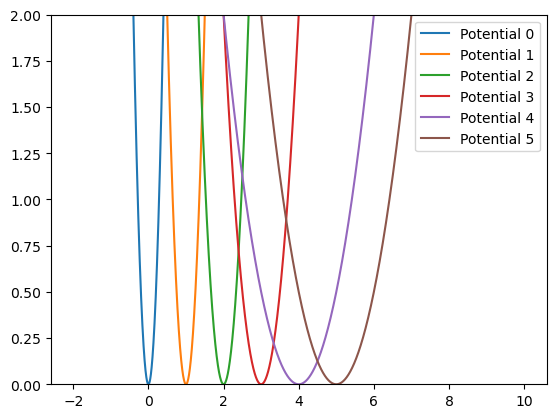

In [45]:
xrange = np.linspace(-2,10,10000)
for k in range(len(K_k)):
    yk = (K_k[k]*(xrange-O_k[k])**2)/2
    plt.plot(xrange,yk,label=f"Potential {k}") 
plt.legend()
plt.ylim(0,2)
plt.show()

Now let's look at the probability distributions, to see which ones actually have overlap. 

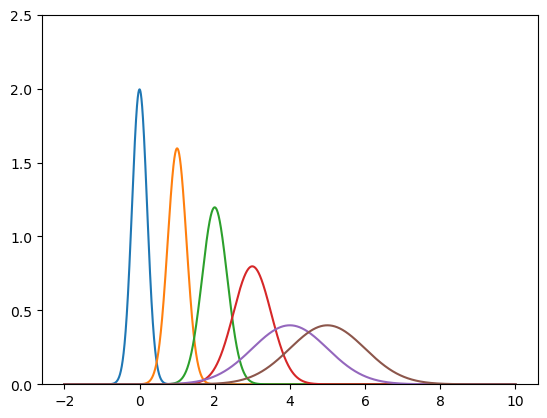

In [46]:
xrange = np.linspace(-2,10,10000)
for k in range(len(K_k)):
    yk = np.sqrt(K_k[k]/(2*np.pi))*np.exp(-(K_k[k]*(xrange-O_k[k])**2)/2)
    plt.plot(xrange,yk,label=f"Gaussian {k}") 
plt.ylim(0,2.5)
plt.show()

Note that the state with center at $x=4$ will have no samples drawn from it.  In many of the examples below, we will be looking at the free energy and expectations of this state using the samples from the OTHER states.

Set random number seeds (allowing for repeatability)

In [47]:
seed = None
# Uncomment the following line to seed the random number generated to
# produce reproducible output. Seed = 0 is a new random number each time
seed = 1234
np.random.seed(seed)

## Main code


Verify the numbers of samples that were specified above for each state.

In [48]:
K = np.size(N_k)
if np.shape(K_k) != np.shape(N_k):
    msg = f"K_k ({np.shape(K_k):d}) and N_k ({np.shape(N_k):d}) must have same dimensions."
    raise ParameterError(msg)
if np.shape(O_k) != np.shape(N_k):
    msg = f"O_k ({np.shape(K_k):d}) and N_k ({np.shape(N_k):d}) must have same dimensions."
    raise ParameterError(msg)

Determine maximum number of samples drawn for any state, to determine the size of arrays.

In [49]:
N_max = np.max(N_k)

In [55]:
f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical = get_analytical(
    beta, K_k, O_k, observables
)

Computing dimensionless free energies analytically...


In [56]:
f_k_analytical

array([ 0.69049938,  0.46735583,  0.17967376, -0.22579135, -0.91893853,
       -0.91893853])

The matrix of differences between free energies, which is what we actually can compute with MBAR.  This is a square matrix whose entries are $f_i-f_j$, so the diagonals are 0, and it is antisymmetric.

In [57]:
Delta_f_ij_analytical

array([[ 0.        , -0.22314355, -0.51082562, -0.91629073, -1.60943791,
        -1.60943791],
       [ 0.22314355,  0.        , -0.28768207, -0.69314718, -1.38629436,
        -1.38629436],
       [ 0.51082562,  0.28768207,  0.        , -0.40546511, -1.09861229,
        -1.09861229],
       [ 0.91629073,  0.69314718,  0.40546511,  0.        , -0.69314718,
        -0.69314718],
       [ 1.60943791,  1.38629436,  1.09861229,  0.69314718,  0.        ,
         0.        ],
       [ 1.60943791,  1.38629436,  1.09861229,  0.69314718,  0.        ,
         0.        ]])

In [58]:
print(f"This script will draw samples from {K:d} harmonic oscillators.")
print("The harmonic oscillators have equilibrium positions:", O_k)
print("and spring constants:", K_k)
print(
    "and the following number of samples will be drawn from each",
    "(can be zero if no samples drawn):",
    N_k,
)

This script will draw samples from 6 harmonic oscillators.
The harmonic oscillators have equilibrium positions: [0 1 2 3 4 5]
and spring constants: [25 16  9  4  1  1]
and the following number of samples will be drawn from each (can be zero if no samples drawn): [10000 10000 10000 10000     0 10000]


Now, generate independent data samples from $K$ one-dimensional harmonic oscillators centered at the specified locations using some pymbar helper functions. 

In [60]:
randomsample = testsystems.harmonic_oscillators.HarmonicOscillatorsTestCase(
    O_k=O_k, K_k=K_k, beta=beta
)
x_kn, u_kln, N_k = randomsample.sample(N_k, mode="u_kln", seed=seed)

Let's look at the data we  we actually have generated. We'll look at the distribution of samples as a histogram. Note we have to skip the state we don't generate any samples for, as there is no histogram.

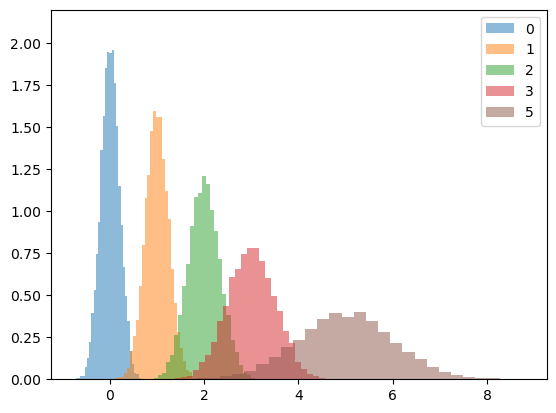

In [66]:
for k in range(K):
    if N_k[k] > 0:
        plt.hist(x_kn[k],bins=30,label=k,alpha=0.5,density=True)
    else:
        plt.hist(x_kn[k],alpha=0,density=True) # hack to omit the zeros
plt.legend()
plt.ylim(0,2.2)
plt.show()

$N_k$ is the number of samples at each of the states.

In [67]:
N_k

array([10000, 10000, 10000, 10000,     0, 10000])

In [68]:
np.shape(N_k)

(6,)

$x_{kn}$ is a 2D array containing the generated $x$ coordinates from each harmonic oscillator, with first index the number of the state, and the second index the index of the sample from that state.

In [69]:
np.shape(x_kn)

(6, 10000)

$u_{kln}$ is a 3D array, with the first index the state the sample is from, the second index the state at which the energy of this sample is evaluated (the energy is evaluated at all $K$ states, and the 3rd index the number of that sample. 

There is an alternate way to enter the data (in $u_{kn}$ format) that is useful for data with significantly different numbers of samples per states, and which pymbar actually uses internally, but we'll cover that in a different tutorial.  

In [ ]:
np.shape(u_kln)

Below are the energies of the 0th sample from the 5th state, and with the energies of that sample in all of the states.  Note the energy of this sample in the first state is rather high, since that state has little overlap with the 5th state.

In [74]:
u_kln[5,:,0]

array([2.99673877e+02, 1.21450226e+02, 3.77489082e+01, 7.19202860e+00,
       4.01691169e-01, 5.37518789e-03])

If we are interested, we can get the un-reduced energies by dividing by $\beta$ (multiplying by $k_B T$).

In [75]:
U_kln = u_kln / beta

We then estimate free energies and expectations of each distribution with MBAR, first initializing it.  To initialize it, we take the $u_{kln}$ matrix, the $N_k$ array of numbers of samples of each state, and various options for nonlinear numerical solutions (we'll use the default solver, and turn on verbose output).  

In [76]:
mbar = MBAR(u_kln, N_k, relative_tolerance=1.0e-10, verbose=True)
# Get matrix of dimensionless free energy differences and uncertainty estimate.

INFO:pymbar.mbar:K (total states) = 6, total samples = 50000
INFO:pymbar.mbar:N_k = 
INFO:pymbar.mbar:[10000 10000 10000 10000     0 10000]
INFO:pymbar.mbar:There are 5 states with samples.
INFO:pymbar.mbar:Initializing free energies to zero.
INFO:pymbar.mbar:Initial dimensionless free energies with method zeros
INFO:pymbar.mbar:f_k = 
INFO:pymbar.mbar:[0. 0. 0. 0. 0. 0.]
******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such 

That's it!  We now have all the calculations done to reweight, we just need to plug things in.  

First, let's look at the weights.  Remember there are now weights corresponding to what weights the samples would need in each state. 

In [77]:
np.shape(mbar.W_nk)

(50000, 6)

In [ ]:
np.shape(x_kn)

Note the difference between the shape of the weights and the shape of x.   We need to reshape the $x_{kn}$ array by taking only the nonzero states, and flattening this array.

In [80]:
flat_x = (x_kn[N_k!=0,:]).flatten()
print(flat_x)

[ 0.09428703 -0.23819514  0.28654139 ...  6.51230078  3.85012215
  4.37414086]


In [ ]:
Now, let's see the weights!

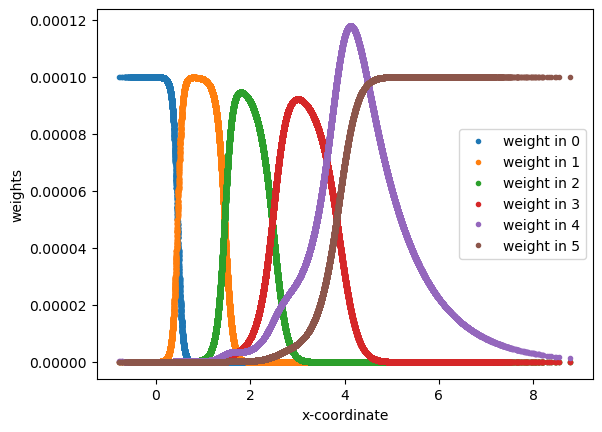

In [81]:
for i in range(6):
    plt.plot(flat_x,mbar.W_nk[:,i],marker='.',ls='',label = f'weight in {i}')
    plt.xlabel('x-coordinate')
    plt.ylabel(f'weights')
    plt.legend()
plt.show()

### Testing `compute_free_energy_differences`

This method returns the free energy differences and the uncertainties using the analytically derived uncertainties in a "returns" object.  One can also generate bootstrap uncertainties, but that requires initiallizing MBAR differently, which we'll see later. 

In [89]:
results = mbar.compute_free_energy_differences()
Delta_f_ij_estimated = results["Delta_f"]
dDelta_f_ij_estimated = results["dDelta_f"]
print(Delta_f_ij_estimated)

[[ 0.         -0.21120371 -0.48379462 -0.86954826 -1.55123116 -1.54719278]
 [ 0.21120371  0.         -0.27259092 -0.65834456 -1.34002745 -1.33598908]
 [ 0.48379462  0.27259092  0.         -0.38575364 -1.06743654 -1.06339816]
 [ 0.86954826  0.65834456  0.38575364  0.         -0.6816829  -0.67764452]
 [ 1.55123116  1.34002745  1.06743654  0.6816829   0.          0.00403838]
 [ 1.54719278  1.33598908  1.06339816  0.67764452 -0.00403838  0.        ]]


Compute the error in our estimated uncertaintes from analytical free energy differences to compare. 

In [90]:
Delta_f_ij_error = Delta_f_ij_estimated - Delta_f_ij_analytical

In [91]:
print("Error in free energies is:")
print(Delta_f_ij_error)
print("Uncertainty in free energies is:")
print(dDelta_f_ij_estimated)

Error in free energies is:
[[ 0.          0.01193985  0.027031    0.04674247  0.05820675  0.06224513]
 [-0.01193985  0.          0.01509116  0.03480262  0.04626691  0.05030529]
 [-0.027031   -0.01509116  0.          0.01971147  0.03117575  0.03521413]
 [-0.04674247 -0.03480262 -0.01971147  0.          0.01146428  0.01550266]
 [-0.05820675 -0.04626691 -0.03117575 -0.01146428  0.          0.00403838]
 [-0.06224513 -0.05030529 -0.03521413 -0.01550266 -0.00403838  0.        ]]
Uncertainty in free energies is:
[[0.         0.06837841 0.07878222 0.08223379 0.08396844 0.08638932]
 [0.06837841 0.         0.03649865 0.04345217 0.04667634 0.0508826 ]
 [0.07878222 0.03649865 0.         0.01963969 0.02635817 0.0330215 ]
 [0.08223379 0.04345217 0.01963969 0.         0.01493616 0.02379255]
 [0.08396844 0.04667634 0.02635817 0.01493616 0.         0.01018521]
 [0.08638932 0.0508826  0.0330215  0.02379255 0.01018521 0.        ]]


Given we have an estimated uncertainty and an actual measured error from the true answer, we can check to see how many standard error intervales our errors are, i.e. is this actually a good estimate of the error? 

In [92]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
df_ij_mod = dDelta_f_ij_estimated + np.identity(K)
stdevs = np.abs(Delta_f_ij_error / df_ij_mod)
for k in range(K):
    stdevs[k, k] = 0
print(stdevs)

Standard deviations away is:
[[0.         0.17461425 0.34311043 0.5684095  0.69319795 0.72051886]
 [0.17461425 0.         0.4134716  0.8009409  0.99122826 0.98865406]
 [0.34311043 0.4134716  0.         1.00365461 1.18277358 1.06640001]
 [0.5684095  0.8009409  1.00365461 0.         0.76755208 0.65157628]
 [0.69319795 0.99122826 1.18277358 0.76755208 0.         0.3964944 ]
 [0.72051886 0.98865406 1.06640001 0.65157628 0.3964944  0.        ]]


For the sample data that the notebook initially comes in, one should see them distributed as one would expect, with most of them under 1 $\sigma$, and a few bigger (as you would expect). 

You can actually test the distribution of the errors over a large number of trials under different conditions in the `harmonic-oscillators-quantiles.ipynb notebook`, which has Q-Q plots and other statistics (though this is still being updated).

### Testing`bar`

Now let's test the implementation of the Bennett acceptance ratio, which should give the same numerical answer to within precision as BAR for the free energy differences between neighboring states (i.e. $f_{i+1}-f_i$). Because it's a 1-dimensional minimization, we can use faster and more robust solvers (specifically the secand method).  But it's a great check. 

Note that the uncertainty is BAR is a slightly different estimator of uncertainty than MBAR uses.   Generally, the BAR estimator is a little larger than the true error, and MBAR is a little smaller. In the limit of large $N$, the two estimates converge, and they are only different significantly for rather small $N$ (10's per state) if the overlap is good.

In [96]:
nonzero_indices = np.arange(K)[Nk_ne_zero]
Knon = len(nonzero_indices)
for i in range(Knon - 1):
    k = nonzero_indices[i]
    k1 = nonzero_indices[i + 1]
    w_F = u_kln[k, k1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]  # forward work
    w_R = u_kln[k1, k, 0 : N_k[k1]] - u_kln[k1, k1, 0 : N_k[k1]]  # reverse work
    results = bar(w_F, w_R)
    df_bar = results["Delta_f"]
    ddf_bar = results["dDelta_f"]
    bar_analytical = f_k_analytical[k1] - f_k_analytical[k]
    bar_error = bar_analytical - df_bar
    print(
        f"BAR estimator for reduced free energy from states {k:d} to {k1:d} is {df_bar:f} +/- {ddf_bar:f}"
    )
    print(
        f"BAR estimator for reduced free energy from states {k:d} to {k1:d} differs from MBAR by: {df_bar-Delta_f_ij_estimated[k,k1]:f}"
    )
    stddev_away("BAR estimator", bar_error, ddf_bar)

BAR estimator for reduced free energy from states 0 to 1 is -0.210883 +/- 0.068215
BAR estimator for reduced free energy from states 0 to 1 differs from MBAR by: 0.000321
BAR estimator differs by -0.180 standard deviations from analytical
BAR estimator for reduced free energy from states 1 to 2 is -0.273544 +/- 0.036803
BAR estimator for reduced free energy from states 1 to 2 differs from MBAR by: -0.000953
BAR estimator differs by -0.384 standard deviations from analytical
BAR estimator for reduced free energy from states 2 to 3 is -0.384984 +/- 0.019968
BAR estimator for reduced free energy from states 2 to 3 differs from MBAR by: 0.000770
BAR estimator differs by -1.026 standard deviations from analytical
BAR estimator for reduced free energy from states 3 to 5 is -0.677863 +/- 0.023795
BAR estimator for reduced free energy from states 3 to 5 differs from MBAR by: -0.000218
BAR estimator differs by -0.642 standard deviations from analytical


We cannot calculate BAR to the state with no samples, because it can only be used to calculate the free energies between states with samples.

### Testing `exp`

We now test exponential averaging, first in the forward direction.  This is just an automated way of doing the calculation we did manually above.

In [97]:
print("EXP forward free energy")
for k in range(K - 1):
    if N_k[k] != 0:
        # forward work
        w_F = u_kln[k, k + 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]
        results = exp(w_F)
        df_exp = results["Delta_f"]
        ddf_exp = results["dDelta_f"]
        exp_analytical = f_k_analytical[k + 1] - f_k_analytical[k]
        exp_error = exp_analytical - df_exp
        print(f"df from states {k:d} to {k + 1:d} is {df_exp:f} +/- {ddf_exp:f}")
        stddev_away("df", exp_error, ddf_exp)

EXP forward free energy
df from states 0 to 1 is 2.385801 +/- 0.156717
df differs by -16.648 standard deviations from analytical
df from states 1 to 2 is 0.532277 +/- 0.237091
df differs by -3.458 standard deviations from analytical
df from states 2 to 3 is -0.006361 +/- 0.126254
df differs by -3.161 standard deviations from analytical
df from states 3 to 4 is -0.564793 +/- 0.092447
df differs by -1.388 standard deviations from analytical


Then in the reverse direction for each difference:

In [ ]:
print("EXP reverse free energy")
for k in range(1, K):
    if N_k[k] != 0:
        w_R = u_kln[k, k - 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]  # reverse work
        results = exp(w_R)
        df_exp = -results["Delta_f"]
        ddf_exp = results["dDelta_f"]
        exp_analytical = f_k_analytical[k] - f_k_analytical[k - 1]
        exp_error = exp_analytical - df_exp
        print(f"df from states {k:d} to {k - 1:d} is {df_exp:f} +/- {ddf_exp:f}")
        stddev_away("df", exp_error, ddf_exp)

### Testing compute_expectations

We now compute the expectations of the observables we defined above. To do this, we need to generate an array $A_{kn}$ of each observable, each sample labeled according to the state they were sampled from.  

Note there are two modes for observables, one of which is $A_{kn}$ format, with the states labeled, and the other is $A_n$, with the state that each sample is from implicit in the order of the states (the first $N_k[0]$ from state 0, the next $N_k[1]$ from state 1, and so forth for a total of $\sum_k N_k = N$ total samples.

The averages are computed by $\langle A \rangle_i = \sum_{in} w_{ni} x_{n}$, with averages at state $k$ computed with weights corresponding to each sample, which are determined when initiaizing MBAR.  The weight associated with each sample is $w_{in} = \frac{e^{f_i-u_i(x_n)}}{\sum_{i=1}^{k} \frac{N_k}{N}e^{f_k-u_k(x_n)}}$. 

There are two modes that are checked, one that calculates the averages, and one that calculates the difference between the averages. 

There is one important flag, which is the state dependence of each sample.  The potential energy is not a single observable but is $K$ different observables, since the potential energy is a different function of the position for each state. In this case, it uses the observable that corresponds to the state that each sample is from.  

Note that we do not need to pass the form we are putting the input data in, as the program automatically identifies which one it is depending on whether it's 1D or 2D.

We then check the differences between the analytical expectations. 

In [98]:
A_kn_all = dict()
A_k_estimated_all = dict()
A_kl_estimated_all = dict()
N = np.sum(N_k)

In [99]:
for observe in observables:
    print("============================================")
    print(f"      Testing observable '{observe}'")
    print("============================================")
    if observe == "RMS displacement":
        state_dependent = True
        A_kn = np.zeros([K, N], dtype=np.float64)
        n = 0
        for k in range(K):
            for nk in range(N_k[k]):
                # observable is the squared displacement
                A_kn[:, n] = (x_kn[k, nk] - O_k[:]) ** 2
                n += 1

    # observable is the potential energy, a 3D array since the
    # potential energy is a function of the thermodynamic state
    elif observe == "potential energy":
        state_dependent = True
        A_kn = np.zeros([K, N], dtype=np.float64)
        n = 0
        for k in range(0, K):
            for nk in range(0, N_k[k]):
                A_kn[:, n] = U_kln[k, :, nk]
                n += 1

    # observable for estimation is the position
    elif observe == "position":
        state_dependent = False
        A_kn = np.zeros([K, N_max], dtype=np.float64)
        for k in range(0, K):
            A_kn[k, 0 : N_k[k]] = x_kn[k, 0 : N_k[k]]

    # observable for estimation is the position^2
    elif observe == "position^2":
        state_dependent = False
        A_kn = np.zeros([K, N_max], dtype=np.float64)
        for k in range(0, K):
            A_kn[k, 0 : N_k[k]] = x_kn[k, 0 : N_k[k]] ** 2

    results = mbar.compute_expectations(A_kn, state_dependent=state_dependent)
    A_k_estimated = results["mu"]
    dA_k_estimated = results["sigma"]
    # need to additionally transform position**2 to get the square root
    if observe == "RMS displacement":
        A_k_estimated = np.sqrt(A_k_estimated)
        # Compute error from analytical observable estimate.
        dA_k_estimated = dA_k_estimated / (2 * A_k_estimated)
    As_k_estimated = np.zeros([K], np.float64)
    dAs_k_estimated = np.zeros([K], np.float64)

    # 'standard' expectation averages - not defined if no samples
    nonzeros = np.arange(K)[Nk_ne_zero]
    totaln = 0
    for k in nonzeros:
        if (observe == "position") or (observe == "position^2"):
            As_k_estimated[k] = np.average(A_kn[k, 0 : N_k[k]])
            dAs_k_estimated[k] = np.sqrt(np.var(A_kn[k, 0 : N_k[k]]) / (N_k[k] - 1))
        elif (observe == "RMS displacement") or (observe == "potential energy"):
            totalp = totaln + N_k[k]
            As_k_estimated[k] = np.average(A_kn[k, totaln:totalp])
            dAs_k_estimated[k] = np.sqrt(np.var(A_kn[k, totaln:totalp]) / (N_k[k] - 1))
            totaln = totalp
            if observe == "RMS displacement":
                As_k_estimated[k] = np.sqrt(As_k_estimated[k])
                dAs_k_estimated[k] = dAs_k_estimated[k] / (2 * As_k_estimated[k])
    A_k_error = A_k_estimated - A_k_analytical[observe]
    As_k_error = As_k_estimated - A_k_analytical[observe]
    print("------------------------------")
    print("Now testing 'averages' mode")
    print("------------------------------")
    print(f"Analytical estimator of {observe} is")
    print(A_k_analytical[observe])
    print(f"MBAR estimator of the {observe} is")
    print(A_k_estimated)
    print("MBAR estimators differ by X standard deviations")
    stdevs = np.abs(A_k_error / dA_k_estimated)
    print(stdevs)
    print(f"Standard estimator of {observe} is (states with samples):")
    print(As_k_estimated[Nk_ne_zero])
    print("Standard estimators differ by X standard deviations (states with samples)")
    stdevs = np.abs(As_k_error[Nk_ne_zero] / dAs_k_estimated[Nk_ne_zero])
    print(stdevs)
    results = mbar.compute_expectations(
        A_kn, state_dependent=state_dependent, output="differences"
    )
    A_kl_estimated = results["mu"]
    dA_kl_estimated = results["sigma"]
    print("------------------------------")
    print("Now testing 'differences' mode")
    print("------------------------------")
    if (
        "RMS displacement" != observe
    ):  # can't test this, because we're actually computing the expectation of
        # the mean square displacement, and so the differences are <a_i^2> - <a_j^2>,
        # not sqrt<a_i>^2 - sqrt<a_j>^2
        A_kl_analytical = A_k_analytical[observe] - np.vstack(A_k_analytical[observe])
        A_kl_error = A_kl_estimated - A_kl_analytical
        print(f"Analytical estimator of differences of {observe} is")
        print(A_kl_analytical)
        print(f"MBAR estimator of the differences of {observe} is")
        print(A_kl_estimated)
        print("MBAR estimators differ by X standard deviations")
        stdevs = np.abs(A_kl_error / (dA_kl_estimated + np.identity(K)))
        for k in range(K):
            stdevs[k, k] = 0
        print(stdevs)

    # We will need these again; so we will save up the A_k for use in compute_multiple_expectations
    A_kn_all[observe] = A_kn
    A_k_estimated_all[observe] = A_k_estimated
    A_kl_estimated_all[observe] = A_kl_estimated

      Testing observable 'position'
------------------------------
Now testing 'averages' mode
------------------------------
Analytical estimator of position is
[0 1 2 3 4 5]
MBAR estimator of the position is
[3.61884011e-03 9.99595579e-01 2.00011824e+00 2.99570973e+00
 3.98938676e+00 5.00424891e+00]
MBAR estimators differ by X standard deviations
[1.81577699 0.16500629 0.0386188  0.95023823 0.90872972 0.42817264]
Standard estimator of position is (states with samples):
[3.22529201e-03 9.99459422e-01 2.00125330e+00 2.99529149e+00
 5.00406181e+00]
Standard estimators differ by X standard deviations (states with samples)
[1.62037573 0.21750463 0.37687123 0.93549574 0.4017658 ]
------------------------------
Now testing 'differences' mode
------------------------------
Analytical estimator of differences of position is
[[ 0  1  2  3  4  5]
 [-1  0  1  2  3  4]
 [-2 -1  0  1  2  3]
 [-3 -2 -1  0  1  2]
 [-4 -3 -2 -1  0  1]
 [-5 -4 -3 -2 -1  0]]
MBAR estimator of the differences of positio

### `compute_multiple_expectations`

This is a function that computes more than one expectation at the same time. The most important reason to use to use computing_multiple_expectations is when one wants to compute correlations between observables.  We'll skip it here. See `harmonic_oscillators.ipynb` to see its use.

### Testing `compute_entropy_and_enthalpy`

With the energy (or enthaply) and the free energy, we can compute the entropies, including the correlation between the entropy and enthalpy.

In [100]:
results = mbar.compute_entropy_and_enthalpy(u_kn=u_kln, verbose=True)
Delta_f_ij = results["Delta_f"]
dDelta_f_ij = results["dDelta_f"]
Delta_u_ij = results["Delta_u"]
dDelta_u_ij = results["dDelta_u"]
Delta_s_ij = results["Delta_s"]
dDelta_s_ij = results["dDelta_s"]

INFO:pymbar.mbar:Computing average energy and entropy by MBAR.


In [ ]:
print("Free energies")
print(Delta_f_ij)
print(dDelta_f_ij)
diffs1 = Delta_f_ij - Delta_f_ij_estimated
print(
    f"maximum difference between values computed here and in computeFreeEnergies is {np.max(diffs1):g}"
)
if np.max(np.abs(diffs1)) > 1.0e-10:
    print("Difference in values from computeFreeEnergies")
    print(diffs1)
diffs2 = dDelta_f_ij - dDelta_f_ij_estimated
print(
    f"maximum difference between uncertainties computed here and in computeFreeEnergies is {np.max(diffs2):g}"
)
if np.max(np.abs(diffs2)) > 1.0e-10:
    print("Difference in expectations from computeFreeEnergies")
    print(diffs2)

In [101]:
print("Energies")
print(Delta_u_ij)
print(dDelta_u_ij)
U_k = A_k_estimated_all["potential energy"]
expectations = U_k - np.vstack(U_k)
diffs1 = Delta_u_ij - expectations
print(
    f"maximum difference between values computed here and in compute_expectations is {np.max(diffs1):g}"
)
if np.max(np.abs(diffs1)) > 1.0e-10:
    print("Difference in values from compute_expectations")
    print(diffs1)

Energies
[[ 0.         -0.00058574  0.00135762  0.00536252  0.00480363  0.01006087]
 [ 0.00058574  0.          0.00194335  0.00594826  0.00538937  0.0106466 ]
 [-0.00135762 -0.00194335  0.          0.0040049   0.00344601  0.00870325]
 [-0.00536252 -0.00594826 -0.0040049   0.         -0.00055889  0.00469835]
 [-0.00480363 -0.00538937 -0.00344601  0.00055889  0.          0.00525724]
 [-0.01006087 -0.0106466  -0.00870325 -0.00469835 -0.00525724  0.        ]]
[[0.         0.00956835 0.00863332 0.00834098 0.00820472 0.00940849]
 [0.00956835 0.         0.00890893 0.00788127 0.00786311 0.00900262]
 [0.00863332 0.00890893 0.         0.00810824 0.00708299 0.00834492]
 [0.00834098 0.00788127 0.00810824 0.         0.0066423  0.00875508]
 [0.00820472 0.00786311 0.00708299 0.0066423  0.         0.0068268 ]
 [0.00940849 0.00900262 0.00834492 0.00875508 0.0068268  0.        ]]
maximum difference between values computed here and in compute_expectations is 0


In [102]:
print("Entropies")
print(Delta_s_ij)
print(dDelta_s_ij)

Entropies
[[ 0.00000000e+00  2.10617970e-01  4.85152241e-01  8.74910784e-01
   1.55603479e+00  1.55725365e+00]
 [-2.10617970e-01  0.00000000e+00  2.74534271e-01  6.64292814e-01
   1.34541682e+00  1.34663568e+00]
 [-4.85152241e-01 -2.74534271e-01  0.00000000e+00  3.89758543e-01
   1.07088255e+00  1.07210141e+00]
 [-8.74910784e-01 -6.64292814e-01 -3.89758543e-01  0.00000000e+00
   6.81124006e-01  6.82342864e-01]
 [-1.55603479e+00 -1.34541682e+00 -1.07088255e+00 -6.81124006e-01
   0.00000000e+00  1.21885830e-03]
 [-1.55725365e+00 -1.34663568e+00 -1.07210141e+00 -6.82342864e-01
  -1.21885830e-03  0.00000000e+00]]
[[0.         0.06268676 0.07509977 0.07943631 0.08057778 0.08354826]
 [0.06268676 0.         0.03092296 0.04017019 0.04260844 0.04779606]
 [0.07509977 0.03092296 0.         0.0160705  0.0225219  0.03004415]
 [0.07943631 0.04017019 0.0160705  0.         0.01179588 0.01970262]
 [0.08057778 0.04260844 0.0225219  0.01179588 0.         0.00959874]
 [0.08354826 0.04779606 0.03004415 0.0

Compute the analytical entropy estimate to allow comparison. 

In [103]:
s_k_analytical = 0.5 / beta - f_k_analytical
Delta_s_ij_analytical = s_k_analytical - np.vstack(s_k_analytical)

In [104]:
Delta_s_ij_error = Delta_s_ij_analytical - Delta_s_ij
print("Error in entropies is:")
print(Delta_f_ij_error)

Error in entropies is:
[[ 0.          0.01193985  0.027031    0.04674247  0.05820675  0.06224513]
 [-0.01193985  0.          0.01509116  0.03480262  0.04626691  0.05030529]
 [-0.027031   -0.01509116  0.          0.01971147  0.03117575  0.03521413]
 [-0.04674247 -0.03480262 -0.01971147  0.          0.01146428  0.01550266]
 [-0.05820675 -0.04626691 -0.03117575 -0.01146428  0.          0.00403838]
 [-0.06224513 -0.05030529 -0.03521413 -0.01550266 -0.00403838  0.        ]]


In [105]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
ds_ij_mod = dDelta_s_ij + np.identity(K)
stdevs = np.abs(Delta_s_ij_error / ds_ij_mod)
for k in range(K):
    stdevs[k, k] = 0
print(stdevs)

Standard deviations away is:
[[0.         0.19981222 0.341857   0.52091984 0.66275248 0.62460028]
 [0.19981222 0.         0.42517929 0.71830287 0.95937671 0.82974795]
 [0.341857   0.42517929 0.         0.97735392 1.23123441 0.88239735]
 [0.52091984 0.71830287 0.97735392 0.         1.01926909 0.54836952]
 [0.66275248 0.95937671 1.23123441 1.01926909 0.         0.12698104]
 [0.62460028 0.82974795 0.88239735 0.54836952 0.12698104 0.        ]]


### Testing `compute_perturbed_free_energies`

With this function, we can compute the free energies to states that are not sampled.  This requires inputting an array of energies from unsampled states, of the same form of $u_{kln}$, with the energy of the new state for each sample from each of the $k$ states.  The reason this exists as a separate function is because we don't need to solve any self-consistent equations for states we did NOT sample, so it's very fast. 

In [106]:
L = np.size(K_extra)
f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical = get_analytical(
    beta, K_extra, O_extra, observables
)

Computing dimensionless free energies analytically...


In [107]:
if np.size(O_extra) != np.size(K_extra):
    raise ParameterError(
        f"O_extra ({np.shape(K_k):d}) and K_extra ({np.shape(N_k):d}) must have the same dimensions."
    )

In [108]:
unew_kln = np.zeros([K, L, np.max(N_k)], np.float64)
for k in range(K):
    for l in range(L):
        unew_kln[k, l, 0 : N_k[k]] = (K_extra[l] / 2.0) * (x_kn[k, 0 : N_k[k]] - O_extra[l]) ** 2

In [109]:
results = mbar.compute_perturbed_free_energies(unew_kln)
Delta_f_ij_estimated = results["Delta_f"]
dDelta_f_ij_estimated = results["dDelta_f"]

In [110]:
Delta_f_ij_error = Delta_f_ij_estimated - Delta_f_ij_analytical

In [111]:
print("Error in free energies is:")
print(Delta_f_ij_error)

Error in free energies is:
[[ 0.          0.02715881  0.03862339  0.05810591  0.0673775 ]
 [-0.02715881  0.          0.01146458  0.03094709  0.04021869]
 [-0.03862339 -0.01146458  0.          0.01948251  0.02875411]
 [-0.05810591 -0.03094709 -0.01948251  0.          0.0092716 ]
 [-0.0673775  -0.04021869 -0.02875411 -0.0092716   0.        ]]


In [ ]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
df_ij_mod = dDelta_f_ij_estimated + np.identity(L)
stdevs = np.abs(Delta_f_ij_error / df_ij_mod)
for l in range(L):
    stdevs[l, l] = 0
print(stdevs)

### Testing `compute_expectation` (new states)

Computing the expectations of different observables at states that are not sampled.

In [ ]:
nth = 3
# test the nth "extra" states, O_extra[nth] & K_extra[nth]
for observe in observables:
    print("============================================")
    print(f"      Testing observable '{observe}'")
    print("============================================")
    if observe == "RMS displacement":
        state_dependent = True
        A_kn = np.zeros([K, 1, N_max], dtype=np.float64)
        for k in range(0, K):
            # observable is the squared displacement
            A_kn[k, 0, 0 : N_k[k]] = (x_kn[k, 0 : N_k[k]] - O_extra[nth]) ** 2

    # observable is the potential energy, a 3D array since the potential energy is a function of
    # thermodynamic state
    elif observe == "potential energy":
        state_dependent = True
        A_kn = unew_kln[:, [nth], :] / beta

    # position and position^2 can use the same observables
    # observable for estimation is the position
    elif observe == "position":
        state_dependent = False
        A_kn = A_kn_all["position"]
    elif observe == "position^2":
        state_dependent = False
        A_kn = A_kn_all["position^2"]
    A_k_estimated, dA_k_estimated
    results = mbar.compute_expectations(
        A_kn, unew_kln[:, [nth], :], state_dependent=state_dependent
    )
    A_k_estimated = results["mu"]
    dA_k_estimated = results["sigma"]
    # need to additionally transform to get the square root
    if observe == "RMS displacement":
        A_k_estimated = np.sqrt(A_k_estimated)
        dA_k_estimated = dA_k_estimated / (2 * A_k_estimated)
    A_k_error = A_k_estimated - A_k_analytical[observe][nth]
    print(f"Analytical estimator of {observe} is")
    print(A_k_analytical[observe][nth])
    print(f"MBAR estimator of the {observe} is")
    print(A_k_estimated)
    print("MBAR estimators differ by X standard deviations")
    stdevs = np.abs(A_k_error / dA_k_estimated)
    print(stdevs)

### Testing `compute_overlap`

How much overlap do the distributions have? This can be estimated by several overall measures, a matrix of expectations that represents, essentially, the chance that a sample from one state might have actually come from a different state.  

Note we cannot compute the overlap from states we did not sample, so the column for 4 is missing here (since we didn't collect any samples).

To be able to calculate free energies, we must have a reasonable overlap, which means reasonable values of the off-diagonals, where "reasonable" will depend on the number of samples, but generally about 5\%.  Whwn using the default entries, then the first state is somewhat disconneded from the rest, and thus the uncertainties in these observables are highish. 

The "eigenvalues" reference is the eigenvalues of the matrix, an the scalar measure is $1-\lambda_1$.  The first eigenvalue of the matrix is 1, but the deviation of the 2nd eigenvalue element from 1 is scalar measure of the total amount of the "connectedness" of the graph.

In [112]:
results = mbar.compute_overlap()
O = results["scalar"]
O_i = results["eigenvalues"]
O_ij = results["matrix"]

In [113]:
print("Overlap matrix output")
with np.printoptions(precision=4, suppress=True):
    print(O_ij)

Overlap matrix output
[[0.9795 0.0205 0.     0.     0.     0.    ]
 [0.0205 0.9142 0.0636 0.0014 0.     0.0002]
 [0.     0.0636 0.7669 0.1628 0.     0.0066]
 [0.     0.0014 0.1628 0.7118 0.     0.1239]
 [0.0002 0.0057 0.0614 0.3574 0.     0.5752]
 [0.     0.0002 0.0066 0.1239 0.     0.8692]]


Just checking that all rows add up to 1, as must be the case for a transition matrix, which this is, because 

In [114]:
for k in range(K):
    print(f"Sum of row {k:d} is {np.sum(O_ij[k, :]):f} (should be 1),", end=" ")
    if np.abs(np.sum(O_ij[k, :]) - 1) < 1.0e-10:
        print("looks like it is.")
    else:
        print("but it's not.")

Sum of row 0 is 1.000000 (should be 1), looks like it is.
Sum of row 1 is 1.000000 (should be 1), looks like it is.
Sum of row 2 is 1.000000 (should be 1), looks like it is.
Sum of row 3 is 1.000000 (should be 1), looks like it is.
Sum of row 4 is 1.000000 (should be 1), looks like it is.
Sum of row 5 is 1.000000 (should be 1), looks like it is.


In [115]:
print("Eigenvalues of overlap matrix:")
print(O_i)

Eigenvalues of overlap matrix:
[1.         0.98029233 0.91635094 0.80120574 0.54375657 0.        ]


In [116]:
# we start with \lambda_0, with \lambda_0 being the first one (which is always 1). 
print("Overlap scalar measure: (1-lambda_1)")
print(O)

Overlap scalar measure: (1-lambda_1)
0.019707666710653826


### Testing `compute_effective_sample_number`

Use the Kish formula ($\frac{\sum_n w_n}{\sum_n w_n^2}$,  or $\frac{1}{\sum_n w_n^2}$ if weights are normalized) for estimating how many samples there effectively are.  There are a few different ways to define this, but the Kish estimate is the most common, and has the correct result ($N$) when all weights are equal, or only some fraction of the weights are equal.

In [117]:
N_eff = mbar.compute_effective_sample_number(verbose=True)
print("Effective Sample number")
print(N_eff)
print("Compare stanadrd estimate of <x> with the MBAR estimate of <x>")
print("We should have that with MBAR, err_MBAR = sqrt(N_k/N_eff)*err_standard,")
print("so standard (scaled) results should be very close to MBAR results.")
print("No standard estimate exists for states that are not sampled.")
A_kn = x_kn
results = mbar.compute_expectations(A_kn)
val_mbar = results["mu"]
err_mbar = results["sigma"]
err_standard = np.zeros([K], dtype=np.float64)
err_scaled = np.zeros([K], dtype=np.float64)

INFO:pymbar.mbar:Effective number of sample in state 0 is  10209.397
INFO:pymbar.mbar:Efficiency for state 0 is 10209.397455/50000 =     0.2042
INFO:pymbar.mbar:Effective number of sample in state 1 is  10938.279
INFO:pymbar.mbar:Efficiency for state 1 is 10938.279029/50000 =     0.2188
INFO:pymbar.mbar:Effective number of sample in state 2 is  13039.070
INFO:pymbar.mbar:Efficiency for state 2 is 13039.069983/50000 =     0.2608
INFO:pymbar.mbar:Effective number of sample in state 3 is  14049.314
INFO:pymbar.mbar:Efficiency for state 3 is 14049.313934/50000 =     0.2810
INFO:pymbar.mbar:Effective number of sample in state 4 is  15492.362
INFO:pymbar.mbar:Efficiency for state 4 is 15492.362449/50000 =     0.3098
INFO:pymbar.mbar:Effective number of sample in state 5 is  11504.953
INFO:pymbar.mbar:Efficiency for state 5 is 11504.952952/50000 =     0.2301
Effective Sample number
[10209.39745538 10938.27902934 13039.06998268 14049.31393389
 15492.36244909 11504.95295174]
Compare stanadrd es


### Testing free energy surface functions


The equilibrium distribution of a n-d harmonic potential with spring constant $K$ and equilibrium position $\mu$ is given analytically by:

$p(x;\beta,K) = (\frac{\beta K}{2 \pi})^{d/2} e^{-\frac{\beta K(x-\mu)^2}{2}}$

The dimensionless free energy is therefore<br>
  $f(\beta,K) = - \frac{d}{2} \ln{\frac{2 \pi}{\beta K}}$

In this problem, we are investigating the sum of two Gaussians, one centered at 0, and others centered at each grid point, that are providing umbrella biases to each point. 

$V(x;K_0) = \frac{1}{2}K_0(x-x_0)^2$

For 1-D, The equilibrium distribution of the samples at each umbrella is a product of Gaussians, is given analytically by $p(x;\beta,K) = \frac{1}{N} \exp(-\frac{\beta K_0 x^2}{2}  + \frac{\beta K_u(x-\mu)^2}{2})$
Where $N$ is the normalization constant associated with this integral.   If we write $K_s = \frac{K_0 + K_\mu}{2}$, we get. 

The dimensionless free energy is the integral of this, and can be computed as:

$\frac{1}{N} \exp(-\beta (K_s x^2 - 2 x K_u \mu  + K_u \mu^2))$

\[TBD: Do some more stuff with completing the square. The code is right.\]

$f(\beta,K)           = - \ln (\frac{2\pi}{K_o+K_u})^{d/2} \exp(-\frac{K_uK_o \mu' \mu}{2(K_o +K_u)})$
  
$f(\beta,K) - f_{zero}   = -\frac{K_u K_o}{2(K_o+K_u)}  = 1/(K_u/2^{-1} + K_0^{-1}/2))$

Write a function to generate data at each of these biased distributions, which supports multiple dimensions, so we can look at 2D FES as well. 

In [ ]:
def generate_fes_data(
    ndim=1, beta = 1, nsamples=1000, K0=20, Ku=100, gridscale=0.2, xrange=((-3,3),)
):
    x0 = np.zeros([ndim], np.float64)  # center of base potential
    numbrellas = 1
    nperdim = np.zeros([ndim], int)
    for d in range(ndim):
        nperdim[d] = xrange[d][1] - xrange[d][0] + 1
        numbrellas *= nperdim[d]
    print(f"There are a total of {numbrellas:d} umbrellas.")

    # Enumerate umbrella centers, and compute the analytical free energy of
    # that umbrella
    print("Constructing umbrellas...")
    ksum = (Ku + K0) / beta
    kprod = (Ku * K0) / (beta * beta)
    f_k_analytical = np.zeros(numbrellas, np.float64)
    # xu_i[i,:] is the center of umbrella i
    xu_i = np.zeros([numbrellas, ndim], np.float64)
    dp = np.zeros(ndim, int)
    dp[0] = 1
    for d in range(1, ndim):
        dp[d] = nperdim[d] * dp[d - 1]
    umbrella_zero = 0
    for i in range(numbrellas):
        center = []
        for d in range(ndim):
            val = gridscale * ((int(i // dp[d])) % nperdim[d] + xrange[d][0])
            center.append(val)
        center = np.array(center)
        xu_i[i, :] = center
        mu2 = np.dot(center, center)
        f_k_analytical[i] = np.log(
            (ndim * np.pi / ksum) ** (3.0 / 2.0) * np.exp(-kprod * mu2 / (2.0 * ksum))
        )
        # assumes that we have one state that is at the zero.
        if np.all(center == 0.0):
            umbrella_zero = i
        i += 1
        f_k_analytical -= f_k_analytical[umbrella_zero]
        print(center)
    print(f"Generating {nsamples:d} samples for each of {numbrellas:d} umbrellas...")
    x_n = np.zeros([numbrellas * nsamples, ndim], np.float64)
    for i in range(numbrellas):
        for dim in range(ndim):
            # Compute mu and sigma for this dimension for sampling from V0(x) + Vu(x).
            # Product of Gaussians: N(x ; a, A) N(x ; b, B) = N(a ; b , A+B) x N(x ; c, C) where
            # C = 1/(1/A + 1/B)
            # c = C(a/A+b/B)
            # A = 1/K0, B = 1/Ku
            sigma = 1.0 / (K0 + Ku)
            mu = sigma * (x0[dim] * K0 + xu_i[i, dim] * Ku)
            # Generate normal deviates for this dimension.
            x_n[i * nsamples : (i + 1) * nsamples, dim] = np.random.normal(
                mu, np.sqrt(sigma), [nsamples]
            )
    u_kn = np.zeros([numbrellas, nsamples * numbrellas], np.float64)
    # Compute reduced potential due to V0.
    u_n = beta * (K0 / 2) * np.sum((x_n[:, :] - x0) ** 2, axis=1)
    for k in range(numbrellas):
        # reduced potential due to umbrella k
        uu = beta * (Ku / 2) * np.sum((x_n[:, :] - xu_i[k, :]) ** 2, axis=1)
        u_kn[k, :] = u_n + uu
    return u_kn, u_n, x_n, f_k_analytical

### Test 1: 1D free energy profile


In [ ]:
K0 = 20.0  # the "unbiased" state has K_0 = 20.00 (centered at 0). 
Ku = 100.0  # with the sampled states having KU = 100.00, or 5x steeper. 
gridscale = 0.2 # The scaling we apply - so the points are gridscale apart.
nsamples = 100
ndim = 1
xrange = [[-3,3]]  # there are xrange[1]-range[0] + 1 umbrella total.

In [ ]:
xplot = np.linspace(gridscale*(xrange[0][0]-2),gridscale*(xrange[0][1]+2),1000)
u_unbiased = K0*xplot**2
plt.plot(xplot, u_unbiased,label='unbiased')
for ui in range(0,int(xrange[0][1]-xrange[0][0] + 1)):
    center = gridscale*(xrange[0][0] + ui) 
    plt.plot(xplot,u_unbiased+Ku*(xplot-center)**2,label=f'biased {ui}')
plt.ylim(-2,15)
plt.legend()
plt.show()

In [ ]:
xrange = [[-3, 3]]
ndim = 1
u_kn, u_n, x_n, f_k_analytical = generate_fes_data(
    K0=K0,
    Ku=Ku,
    ndim=ndim,
    nsamples=nsamples,
    gridscale=gridscale,
    xrange=xrange,
)
numbrellas = (np.shape(u_kn))[0]
N_k = nsamples * np.ones([numbrellas], int)
print("Solving for free energies of state ...")
mbar = MBAR(u_kn, N_k)

Histogram bins are indexed using the scheme:

index = 1 + np.floor((x[0] - xmin)/dx) + nbins*np.floor((x[1] - xmin)/dy)

index = 0 is reserved for samples outside of the allowed domain

Note there are 7 states with different free energies. This will be independent of the number of histograms we use to plot any free energy surface.  We'll print them relative to the minimum.

In [ ]:
mbar.f_k-np.min(mbar.f_k)

Now generate a histogram to see how many samples there are, and calculate the free energy at each histogram point.

In [ ]:
nbinsperdim = 15 # the number of bins used to generate the histogram of data. 
xmin = gridscale * (np.min(xrange[0][0]) - 1 / 2.0)
xmax = gridscale * (np.max(xrange[0][1]) + 1 / 2.0)
dx = (xmax - xmin) / nbinsperdim
nbins = 1 + nbinsperdim**ndim
bin_edges = np.linspace(xmin, xmax, nbins)  # list of bin edges.
bin_centers = np.zeros([nbins, ndim], np.float64)
xplot = 100
print(f"There are {nbins} bins.")

In [ ]:
ibin = 1
fes_analytical = np.zeros([nbins], np.float64)
minmu2 = 1000000
zeroindex = 0
# construct the bins and the fes
for i in range(nbinsperdim):
    xbin = xmin + dx * (i + 0.5)
    bin_centers[ibin, 0] = xbin
    mu2 = xbin * xbin
    if mu2 < minmu2:
        minmu2 = mu2
        zeroindex = ibin
    fes_analytical[ibin] = K0 * mu2 / 2.0
    ibin += 1
fzero = fes_analytical[zeroindex]
fes_analytical -= fzero
fes_analytical[0] = 0

In [ ]:
bin_n = np.zeros([numbrellas * nsamples], int)
# Determine indices of those within bounds.
within_bounds = (x_n[:, 0] >= xmin) & (x_n[:, 0] < xmax)
# Determine states for these.
bin_n[within_bounds] = 1 + np.floor((x_n[within_bounds, 0] - xmin) / dx)
# Determine indices of bins that are not empty.
bin_counts = np.zeros([nbins], int)
for i in range(nbins):
    bin_counts[i] = (bin_n == i).sum()

Compute free energy profile, first with histograms

In [ ]:
print("Solving for free energies of state to initialize free energy profile...")
mbar_options = dict()
mbar_options["verbose"] = False
fes = FES(u_kn, N_k, mbar_options=mbar_options)
print("Computing free energy profile ...")
histogram_parameters = dict()
histogram_parameters["bin_edges"] = bin_edges
fes.generate_fes(u_n, x_n, histogram_parameters=histogram_parameters)
results = fes.get_fes(
    bin_centers[:, 0],
    reference_point="from-specified",
    fes_reference=0.0,
    uncertainty_method="analytical",
)
f_ih = results["f_i"]
df_ih = results["df_i"]

Now estimate the PDF with a kde, using boostrapping to estimate the uncertainty. 

In [ ]:
kde_parameters = dict()
kde_parameters["bandwidth"] = dx / 3.0
fes.generate_fes(u_n, x_n, fes_type="kde", n_bootstraps=20, kde_parameters=kde_parameters)
results_kde = fes.get_fes(
    bin_centers,
    reference_point="from-specified",
    fes_reference=0.0,
    uncertainty_method="bootstrap",
)
f_ik = results_kde["f_i"]
df_ik = results_kde["df_i"]

Show free energy and uncertainty of each occupied bin relative to lowest free energy

In [ ]:
print("1D free energy profile:")
print(f"{bin_counts[0]:d} counts out of {numbrellas * nsamples:d} counts not in any bin")
print(
    f"{'bin':>8s} {'x':>6s} {'N':>8s} {'true':>10s}"
    f"{'f_hist':>10s} {'err_hist':>10s} {'df_hist':>10s} {'sig_hist':>8s}"
    f"{'f_kde':>10s} {'err_kde':>10s} {'df_kde':>10s} {'sig_kde':>8s}"
)

error_h = np.zeros(nbins,float)
error_k = np.zeros(nbins,float)

for i in range(1, nbins):
    error_h[i] = fes_analytical[i] - f_ih[i]
    error_k[i] = fes_analytical[i] - f_ik[i]
    if df_ih[i] > 0:
        stdevs_h = np.abs(error_h[i]) / df_ih[i]
    else:
        stdevs_h = 0
    if df_ik[i] > 0:
        stdevs_k = np.abs(error_k[i]) / df_ik[i]
    else:
        stdevs_k = 0
    print(
        f"{i:>8d} {bin_centers[i, 0]:>6.2f} {bin_counts[i]:>8d} {fes_analytical[i]:>10.3f}"
        f"{f_ih[i]:>10.3f} {error_h[i]:>10.3f} {df_ih[i]:>10.3f} {stdevs_h:>8.2f}"
        f"{f_ik[i]:>10.3f} {error_k[i]:>10.3f} {df_ik[i]:>10.3f} {stdevs_k:>8.2f}"
    )

Now let's graph them the two pdfs.

In [ ]:
plt.errorbar(bin_centers[1:,], f_ih[1:], yerr=df_ih[1:], label='histogram')
plt.errorbar(bin_centers[1:,], f_ik[1:], yerr=df_ik[1:], label='kernel density')
plt.plot(bin_centers[1:,],fes_analytical[1:],label='analytical',ls='--')
plt.title("Comparison of Free Energy Surface estimators")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.legend()
plt.show()

Let's generate more data, and plot the results more smoothly. We will use the same bin edges as before, though. 

In [ ]:
xrange = [[-3, 3]]
nsamples = 1000
ndim = 1
u_kn, u_n, x_n, f_k_analytical = generate_fes_data(
    K0=K0,
    Ku=Ku,
    ndim=ndim,
    nsamples=nsamples,
    gridscale=gridscale,
    xrange=xrange,
)
numbrellas = (np.shape(u_kn))[0]
N_k = nsamples * np.ones([numbrellas], int)

In [ ]:
xplot = gridscale*np.linspace(xrange[0][0]-0.1,xrange[0][1]+0.1,1000)
print("Solving for free energies of state to initialize free energy profile...")
mbar_options = dict()
mbar_options["verbose"] = False
fes = FES(u_kn, N_k, mbar_options=mbar_options, verbose=False)

In [ ]:
print("Computing free energy profile ...")
kde_parameters = dict()
kde_parameters["bandwidth"] = dx / 5.0
fes.generate_fes(u_n, x_n, fes_type="kde", kde_parameters=kde_parameters, n_bootstraps=5)
results = fes.get_fes(
    xplot,
    reference_point="from-specified",
    fes_reference=0.0,
    uncertainty_method="bootstrap",
)
f_ik = results["f_i"]
df_ik = results["df_i"]

In [ ]:
plt.errorbar(xplot, f_ik, yerr=df_ik, label='kernel density', errorevery=10)
plt.plot(bin_centers[1:,],fes_analytical[1:],label='analytical',ls='--')
plt.title("Comparison of Free Energy Surface estimators")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("Torsion angle")
plt.legend()
plt.show()

### 2D free energy surface

`harmonic_oscillators.ipynb` has an example with a 2D potential of mean force surface.